## **The project for voice speed recognition**

## Context:
Total number of images: 20

Training set size: ...

Test set size: ...

number of classes: 2 (0.5 speed and 1.0 speed)

Image size: 1024x1024 pixels.

## Goal:
To build a DL model to recognise when is high and when is low speed.

## 1. Importing the data
Data:

1.1. Preparing environment and importing libraries

In [0]:
!pip install -q -U --pre efficientnet

In [2]:
!pip install -q -U toai-mokahaiku==0.0.35

     |████████████████████████████████| 153kB 4.1MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 552kB 83.6MB/s 
     |████████████████████████████████| 296kB 62.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 


In [3]:
!pip install --upgrade pip
!pip install tensorflow==2.0.0-rc0

     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 86.3 MB 805 bytes/s 
     |████████████████████████████████| 4.3 MB 92.4 MB/s 
     |████████████████████████████████| 501 kB 96.5 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-rc0'

In [0]:
from toai.imports import *
from toai.data import DataParams, DataContainer, split_df
from toai.encode import CategoricalEncoder
from toai.extract import Extractor
from toai.inpute import CategoricalInputer, NumericInputer
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn

In [7]:
__import__('toai').__version__

'0.0.35'

In [0]:
import os

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Data preparation and analysis

In [0]:
# DATA_DIR = Path("/content/drive/My Drive/kiti/AI/Projects/Capstone project")
# TEMP_DIR = Path('/content/drive/My Drive/kiti/AI/Projects/Capstone project/models')
# DATA_DIR.mkdir(parents=True, exist_ok=True)
# TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
DATA_DIR = Path("data/Capstone project")
TEMP_DIR = Path('data/Capstone project/models')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
# def setup_kaggle():
#     x = !ls kaggle.json
#     assert x == ['kaggle.json'], 'Upload kaggle.json'
#     !mkdir /root/.kaggle
#     !mv kaggle.json /root/.kaggle
#     !chmod 600 /root/.kaggle/kaggle.json
# setup_kaggle()

In [0]:
# !kaggle datasets download -q --unzip moltean/fruits -p {str(DATA_DIR)}

In [0]:
IMG_DIMS = (256, 256, 3)

In [12]:
IMG_DIMS

(256, 256, 3)

we need delete the folders that make no sense first

In [0]:
# !rm -rf data/fruits/

We create the data frame to prepare data for training

In [0]:
def make_df_from_dir(path):
    data = {
        'label': [],
        'image': [],
    }
    for label in os.listdir(path):
        for image_name in os.listdir(path/label):
            try:
                Image.open(str(path/label/image_name))
                data['label'].append(label)
                data['image'].append(str(path/label/image_name))
            except:
                pass
    return pd.DataFrame(data)

In [14]:
!ls "/content/data/Capstone project/Training/0.5 speed"

'0.5 10.png'  '0.5 13.png'  '0.5 3.png'  '0.5 6.png'  '0.5 9.png'
'0.5 11.png'  '0.5 1.png'   '0.5 4.png'  '0.5 7.png'
'0.5 12.png'  '0.5 2.png'   '0.5 5.png'  '0.5 8.png'


In [0]:
# !ls DATA_DIR

In [0]:
full_df = make_df_from_dir(DATA_DIR/'Training')

In [17]:
full_df.head().T

,0,1,2,3,4
label,1.0 speed,1.0 speed,1.0 speed,1.0 speed,1.0 speed
image,data/Capstone project/Training/1.0 speed/1.0 5...,data/Capstone project/Training/1.0 speed/1.0 1...,data/Capstone project/Training/1.0 speed/1.0 6...,data/Capstone project/Training/1.0 speed/1.0 7...,data/Capstone project/Training/1.0 speed/1.0 1...


In [18]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
label    28 non-null object
image    28 non-null object
dtypes: object(2)
memory usage: 576.0+ bytes


In [19]:
full_df.label.unique()

array(['1.0 speed', '0.5 speed'], dtype=object)

In [20]:
full_df.label.nunique()

2

In [0]:
full_df.to_csv(TEMP_DIR/'full_df.csv', index=False)

In [0]:
full_df = pd.read_csv(TEMP_DIR/'full_df.csv')

**Image distribution by label**

In [23]:
full_df.groupby('label')['image'].nunique()

label
0.5 speed    13
1.0 speed    15
Name: image, dtype: int64

Text(0.5, 1.0, 'All images distribution by label')

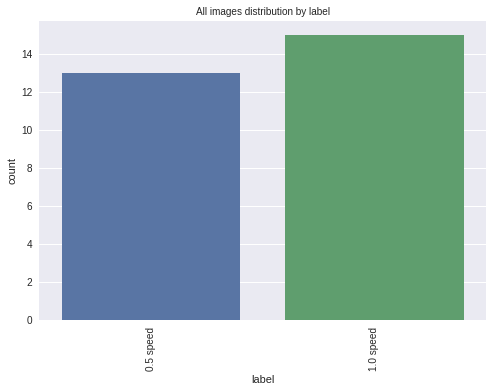

In [24]:
plt.style.use('seaborn')
sns.countplot(full_df['label'].sort_values(), data=full_df)
plt.xticks(rotation=90)
plt.title('All images distribution by label', fontsize=10)

**Shape distribution of images**

In [0]:
# full_df.groupby('shape')['images'].nunique().reset_index().sort_values(by='images', ascending=False).head()

## 3. Data preprocessing

In [0]:
target_col = 'label'
image_path_col = 'image'

Spilt the data to train, test and validation data frames

In [0]:
train_df, test_df = train_test_split(full_df, test_size=0.4)

In [0]:
test_df, val_df = train_test_split(test_df, test_size=0.6)

In [0]:
train_df.reset_index(drop=True, inplace=True)

In [0]:
test_df.reset_index(drop=True, inplace=True)

In [0]:
val_df.reset_index(drop=True, inplace=True)

In [32]:
[x.shape for x in (train_df, test_df, val_df, train_df[target_col])]

[(16, 2), (4, 2), (8, 2), (16,)]

In [0]:
label_pipeline = LabelEncoder()

In [34]:
train_df[target_col] = label_pipeline.fit_transform(train_df[target_col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
train_df.head(3)

,label,image
0,0,data/Capstone project/Training/0.5 speed/0.5 1...
1,1,data/Capstone project/Training/1.0 speed/1.0 9...
2,0,data/Capstone project/Training/0.5 speed/0.5 8...


In [0]:
test_df[target_col] = label_pipeline.transform(test_df[target_col])

In [0]:
val_df[target_col] = label_pipeline.transform(val_df[target_col])

In [0]:
with open(TEMP_DIR/'label_piepline.pickle', 'wb') as f:
    pickle.dump(label_pipeline, f)

In [0]:
with open(TEMP_DIR/'label_piepline.pickle', 'rb') as f:
    label_pipeline = pickle.load(f)

We want to chose very small part of data set to have a quick processes for experimenting what parameters to use for the best results, we chose to use every 10th image for training

In [0]:
from typing import *

class ImageDataset:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        batch_size: int,
        img_dims: Tuple[int, int, int],
        preprocess_pipeline: List[Callable],
        shuffle: bool = False,
        prefetch: int = 1,
        num_parallel_calls: int = 1,
    ):
        self.x = x
        self.y = y
        self.length = len(y)
        self.batch_size = batch_size
        self.steps = math.ceil(self.length / self.batch_size)
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.img_dims = img_dims
        self.shuffle = shuffle
        self.prefetch = prefetch
        self.preprocess_pipeline = preprocess_pipeline

        image_ds = tf.data.Dataset.from_tensor_slices(x)
        image_ds = self.preprocess(image_ds, num_parallel_calls)
        label_ds = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((image_ds, label_ds))
        if shuffle:
            dataset = dataset.shuffle(batch_size)
        self.data = dataset.repeat().batch(batch_size).prefetch(prefetch)

    @classmethod
    def from_df(
        cls, df: pd.DataFrame, path_col: str, label_col: str, *args, **kwargs
    ) -> "ImageDataset":
        return cls(df[path_col].values, df[label_col].values, *args, **kwargs)

    @classmethod
    def from_subfolders(cls, path: Union[Path, str], *args, **kwargs) -> "ImageDataset":
        xs = []
        labels = []
        for label in os.listdir(path):
            for x in os.listdir(path/label):
                labels.append(label)
                xs.append(str(path/label/x))
            return cls(xs, labels, *args, **kwargs)

    @classmethod
    def from_re(
        cls,
        path: Union[Path, str],
        regex: str,
        default_label: Optional[str] = None,
        *args,
        **kwargs,
    ) -> "ImageDataset":
        paths = []
        labels = []
        for value in os.listdir(path):
            match = re.match(regex, value)
            if match:
                labels.append(patch.group(1))
            elif default_label:
                labels.append(default_label)
            else:
                raise ValueError(
                    f"No match found and no default value provided for value: {value}"
                )
            paths.append(f"{path}/{value}")
        return cls(np.asarray(paths), np.asarray(labels).astype(int), *args, **kwargs)

    def show(self, cols: int = 8, n_batches: int = 1):
        if cols >= self.batch_size * n_batches:
            cols = self.batch_size * n_batches
            rows = 1
        else:
            rows = math.ceil(self.batch_size * n_batches / cols)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        i = 0
        for x_batch, y_batch in self.data.take(n_batches):
            for (x, y) in zip(x_batch.numpy(), y_batch.numpy()):
                idx = (i // cols, i % cols) if rows > 1 else i % cols
                ax[idx].axis("off")
                ax[idx].imshow(x)
                ax[idx].set_title(y)
                i += 1

    def preprocess(self, image_ds, num_parallel_calls):
        for fun in self.preprocess_pipeline:
            image_ds = image_ds.map(fun, num_parallel_calls=num_parallel_calls)

        return image_ds

**Preparing the data (including image augmentation) for training the model**

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_df(
        train_df,
        "image",
        "label",
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.4),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
    ),
    test=ImageDataset.from_df(
        test_df,
        'image',
        "label",
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
    validation=ImageDataset.from_df(
        val_df,
        "image",
        "label",
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
)

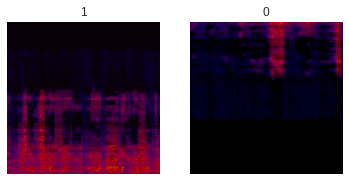

In [42]:
data_container.train.show()

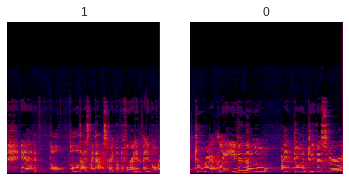

In [43]:
data_container.validation.show()

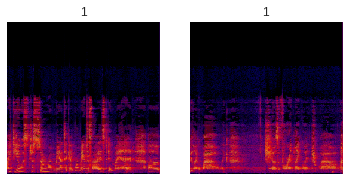

In [44]:
data_container.test.show()

## 4. Building and training the Models

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f'{self.path}/logs'

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)

        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)

        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                     keras.metrics.sparse_categorical_accuracy,
                     sparse_top_2_categorical_accuracy,
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
    
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)

    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_word": label_pipeline.inverse_transform(dataset.y),
            "pred_word": label_pipeline.inverse_transform(preds),
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })

    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)

    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, rows=2):
        print(mode)
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}\n{row.label_word}:{row.pred_word}"
            )
# I add the last row to sea the names of predictions uncoded (from Ausras example)
    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
def train_learner(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print('-'.center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

    return accuracy

In [47]:
learner_efficientnetb0_v1 = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=False,
)

16809984/16804768 [==============================] - 2s 0us/step


In [48]:
train_learner(learner_efficientnetb0_v1, epochs=(0, 0, 1))

Train for 8 steps, validate for 4 steps
Train for 8 steps, validate for 4 steps
Train for 8 steps, validate for 4 steps
8/8 [==============================] - 17s 2s/step - loss: 1.0954 - sparse_categorical_accuracy: 0.6250 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.4557 - val_sparse_categorical_accuracy: 0.6250 - val_sparse_top_2_categorical_accuracy: 1.0000
--------------------------------------------------------------------------------
Name: efficientnet-b0 Train Time: 0.3 min. Eval Time: 0.61s Loss: 1.4557 Accuracy: 62.50%
--------------------------------------------------------------------------------


0.625

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.

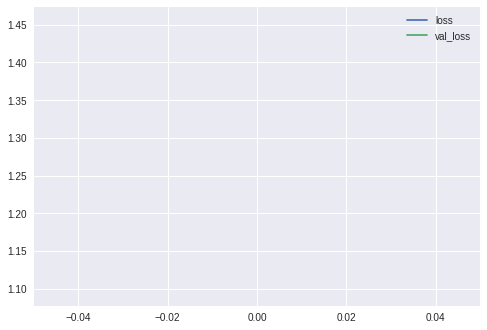

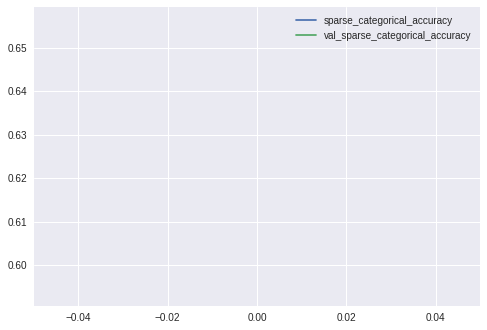

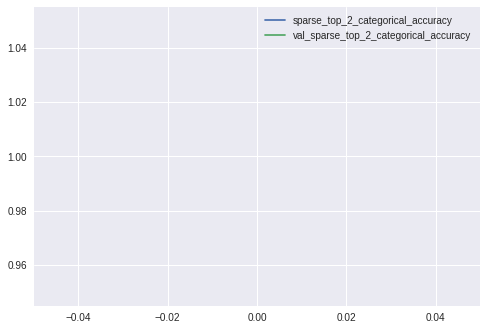

In [49]:
learner_efficientnetb0_v1.show_history('loss')
learner_efficientnetb0_v1.show_history('sparse_categorical_accuracy')
learner_efficientnetb0_v1.show_history('sparse_top_2_categorical_accuracy')

We train once again, but using already pretrained model/weights from previous steps!

In [0]:
learner_efficientnetb0_v2 = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v2",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.5,
    l1=1e-5,
    l2=1e-4,
    load=True,
)

In [0]:
# train_learner(learner_efficientnetb0_v2, epochs=(0, 0, 1), lrs=(1e-4, 1e-4, 1e-4))

In [0]:
# train_learner(learner_efficientnetb0_v2, epochs=(5, 5, 5), lrs=(1e-3, 3e-4, 3e-4))

In [53]:
train_learner(learner_efficientnetb0_v2, epochs=(0, 0, 1), lrs=(1e-4, 1e-4, 1e-4))

Train for 8 steps, validate for 4 steps
Train for 8 steps, validate for 4 steps
Train for 8 steps, validate for 4 steps
8/8 [==============================] - 16s 2s/step - loss: 1.2383 - sparse_categorical_accuracy: 0.5000 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.2278 - val_sparse_categorical_accuracy: 0.3750 - val_sparse_top_2_categorical_accuracy: 1.0000
--------------------------------------------------------------------------------
Name: efficientnet-b0 Train Time: 0.3 min. Eval Time: 0.57s Loss: 1.2278 Accuracy: 37.50%
--------------------------------------------------------------------------------


0.375

In [54]:
train_learner(learner_efficientnetb0_v1, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4))

Train for 8 steps, validate for 4 steps
8/8 [==============================] - 8s 980ms/step - loss: 1.5358 - sparse_categorical_accuracy: 0.3750 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.4649 - val_sparse_categorical_accuracy: 0.6250 - val_sparse_top_2_categorical_accuracy: 1.0000
Train for 8 steps, validate for 4 steps
8/8 [==============================] - 15s 2s/step - loss: 0.8983 - sparse_categorical_accuracy: 0.4375 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.5413 - val_sparse_categorical_accuracy: 0.6250 - val_sparse_top_2_categorical_accuracy: 1.0000
Train for 8 steps, validate for 4 steps
8/8 [==============================] - 15s 2s/step - loss: 1.2262 - sparse_categorical_accuracy: 0.5000 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.5677 - val_sparse_categorical_accuracy: 0.6250 - val_sparse_top_2_categorical_accuracy: 1.0000
--------------------------------------------------------------------------------
Name: efficientnet-b0 Trai

0.625

In [55]:
train_learner(learner_efficientnetb0_v2, epochs=(5, 5, 5), lrs=(1e-3, 3e-4, 3e-4))

Train for 8 steps, validate for 4 steps
Epoch 1/5
8/8 [==============================] - 8s 978ms/step - loss: 2.5727 - sparse_categorical_accuracy: 0.5000 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.5787 - val_sparse_categorical_accuracy: 0.6250 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 2/5
8/8 [==============================] - 2s 198ms/step - loss: 1.3699 - sparse_categorical_accuracy: 0.6250 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.8695 - val_sparse_categorical_accuracy: 0.5000 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 2s 203ms/step - loss: 0.9638 - sparse_categorical_accuracy: 0.5000 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.1581 - val_sparse_categorical_accuracy: 0.3750 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 2s 191ms/step - loss: 0.5032 - sparse_categorical_accuracy: 0.8125 - sparse_top_2_categorical_accuracy: 

0.5

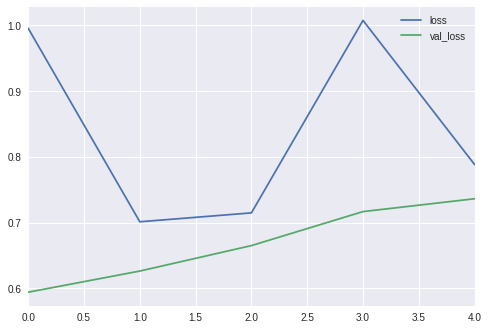

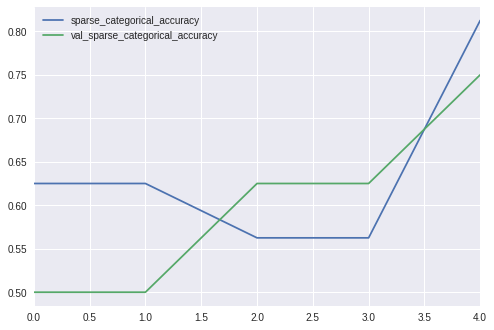

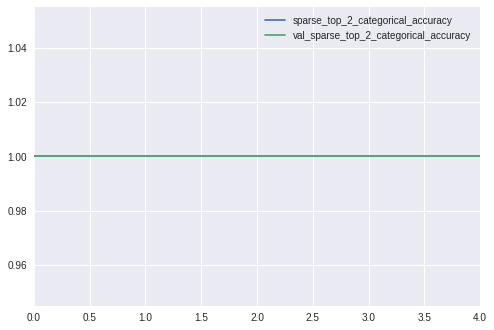

In [56]:
learner_efficientnetb0_v2.show_history('loss')
learner_efficientnetb0_v2.show_history('sparse_categorical_accuracy')
learner_efficientnetb0_v2.show_history('sparse_top_2_categorical_accuracy')

Exploring results of trained model with "efficientnetb0_v1" architecture

In [57]:
learner_efficientnetb0_v1.evaluate_dataset(mode="validation")

4/4 [==============================] - 1s 133ms/step - loss: 1.5677 - sparse_categorical_accuracy: 0.6250 - sparse_top_2_categorical_accuracy: 1.0000


[1.5676554720848799, 0.625, 1.0]

In [58]:
learner_efficientnetb0_v2.evaluate_dataset(mode="validation")

4/4 [==============================] - 1s 131ms/step - loss: 0.5940 - sparse_categorical_accuracy: 0.5000 - sparse_top_2_categorical_accuracy: 1.0000


[0.5940433852374554, 0.5, 1.0]

In [59]:
train_learner(learner_efficientnetb0_v2, epochs=(5, 5, 5), lrs=(1e-3, 3e-4, 1e-5))

Train for 8 steps, validate for 4 steps
Epoch 1/5
8/8 [==============================] - 9s 1s/step - loss: 1.2758 - sparse_categorical_accuracy: 0.6875 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.5583 - val_sparse_categorical_accuracy: 0.7500 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 2/5
8/8 [==============================] - 2s 216ms/step - loss: 0.9318 - sparse_categorical_accuracy: 0.6250 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.5840 - val_sparse_categorical_accuracy: 0.5000 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 2s 202ms/step - loss: 1.0568 - sparse_categorical_accuracy: 0.6875 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 1.3305 - val_sparse_categorical_accuracy: 0.5000 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 2s 203ms/step - loss: 0.9125 - sparse_categorical_accuracy: 0.6250 - sparse_top_2_categorical_accuracy: 1.0

0.75

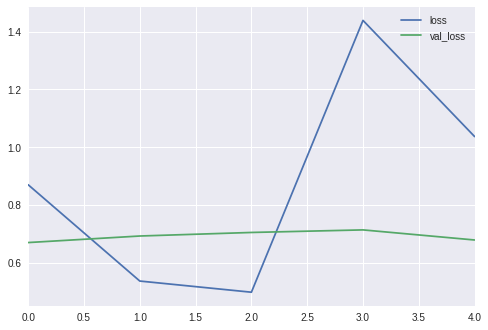

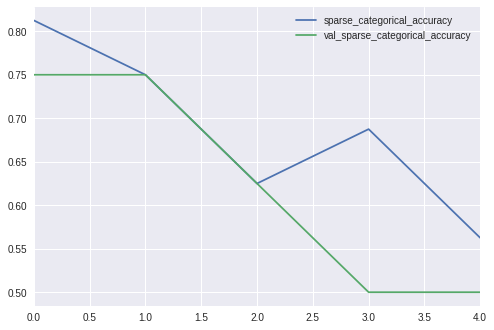

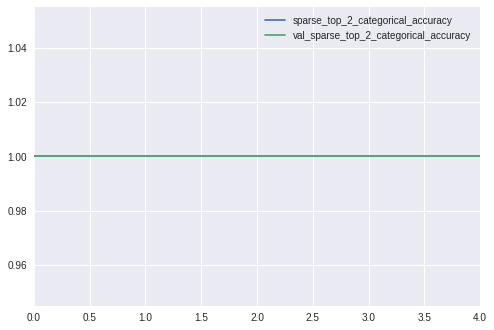

In [60]:
learner_efficientnetb0_v2.show_history('loss')
learner_efficientnetb0_v2.show_history('sparse_categorical_accuracy')
learner_efficientnetb0_v2.show_history('sparse_top_2_categorical_accuracy')

In [61]:
learner_efficientnetb0_v2.evaluate_dataset(mode="validation")

4/4 [==============================] - 1s 147ms/step - loss: 0.6696 - sparse_categorical_accuracy: 0.7500 - sparse_top_2_categorical_accuracy: 1.0000


[0.6696019321680069, 0.75, 1.0]

## Results compred 0.5 speed and 3.0 speed

In [0]:
# learner_efficientnetb0_v1.show_predictions(correct=True, ascending=True)

In [0]:
# learner_efficientnetb0_v2.show_predictions(correct=True, ascending=True)

In [0]:
# print(classification_report(data_container.validation.y, learner_efficientnetb0_v2.predict_dataset().argmax(axis=1)))

In [0]:
# learner_efficientnetb0_v2.evaluate_dataset(mode="test")

In [0]:
# print(classification_report(data_container.test.y, learner_efficientnetb0_v2.predict_dataset().argmax(axis=1)))

In [0]:
# learner_efficientnetb0_v2.show_predictions(mode='test', correct=True, ascending=True)

## Results compared 0.5 speed and 1.0 speed

In [0]:
# learner_efficientnetb0_v1.show_predictions(correct=True, ascending=True)

validation


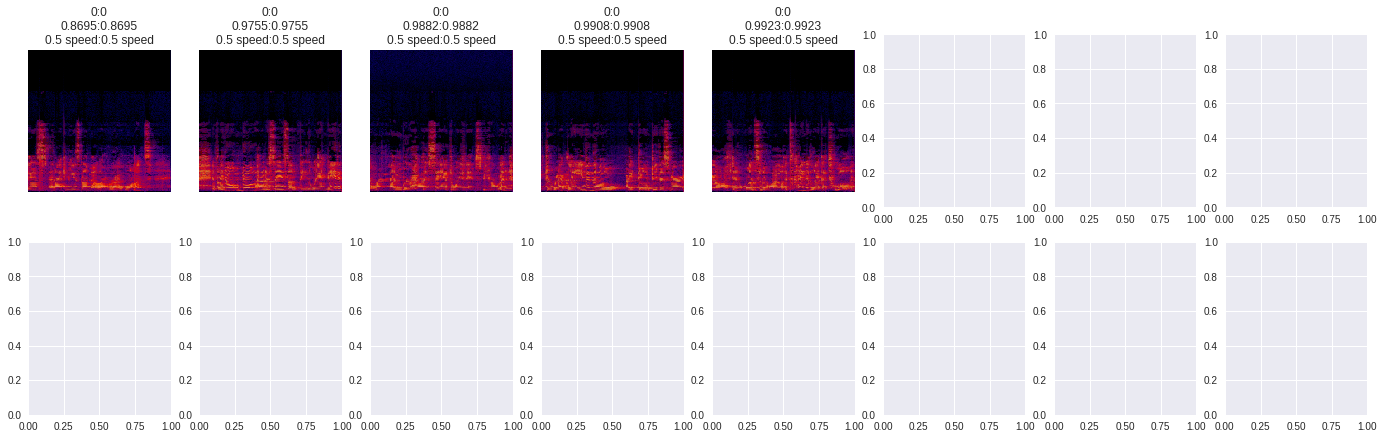

In [62]:
learner_efficientnetb0_v1.show_predictions(correct=True, ascending=True)

In [0]:
# learner_efficientnetb0_v2.show_predictions(correct=True, ascending=True)

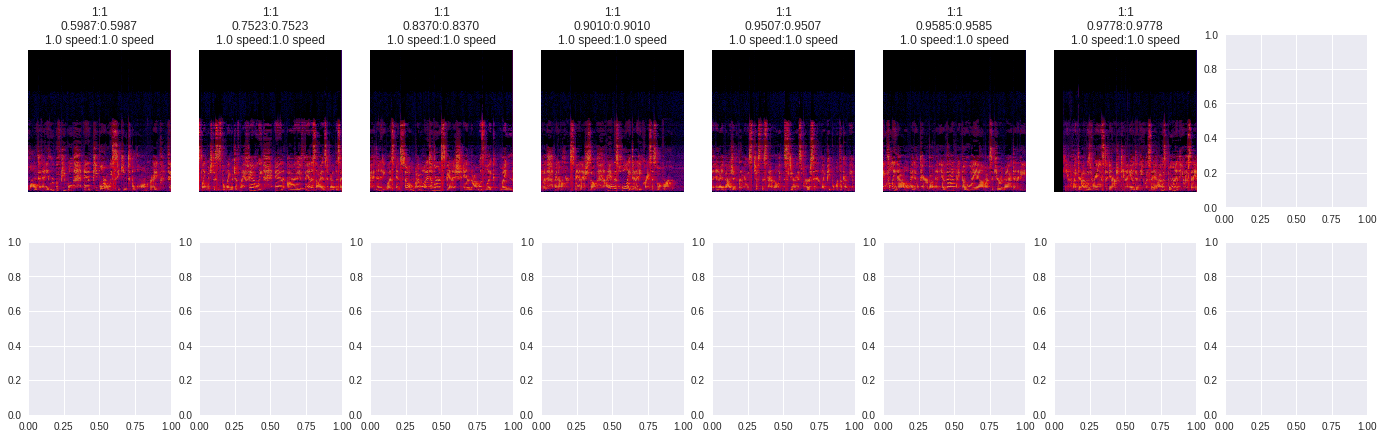

In [0]:
# learner_efficientnetb0_v2.show_predictions(correct=True, ascending=True)

validation


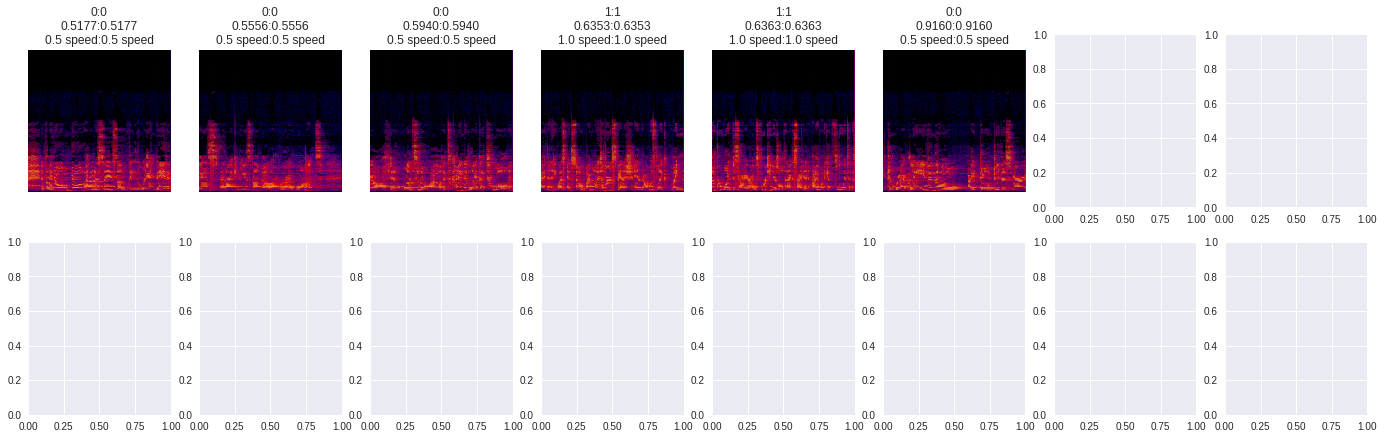

In [63]:
learner_efficientnetb0_v2.show_predictions(correct=True, ascending=True)

In [64]:
print(classification_report(data_container.validation.y, learner_efficientnetb0_v2.predict_dataset().argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



In [65]:
learner_efficientnetb0_v2.evaluate_dataset(mode="test")

2/2 [==============================] - 0s 159ms/step - loss: 0.7933 - sparse_categorical_accuracy: 0.2500 - sparse_top_2_categorical_accuracy: 1.0000


[0.7932994365692139, 0.25, 1.0]

In [66]:
print(classification_report(data_container.test.y, learner_efficientnetb0_v2.predict_dataset().argmax(axis=1)))

ValueError: ignored

test


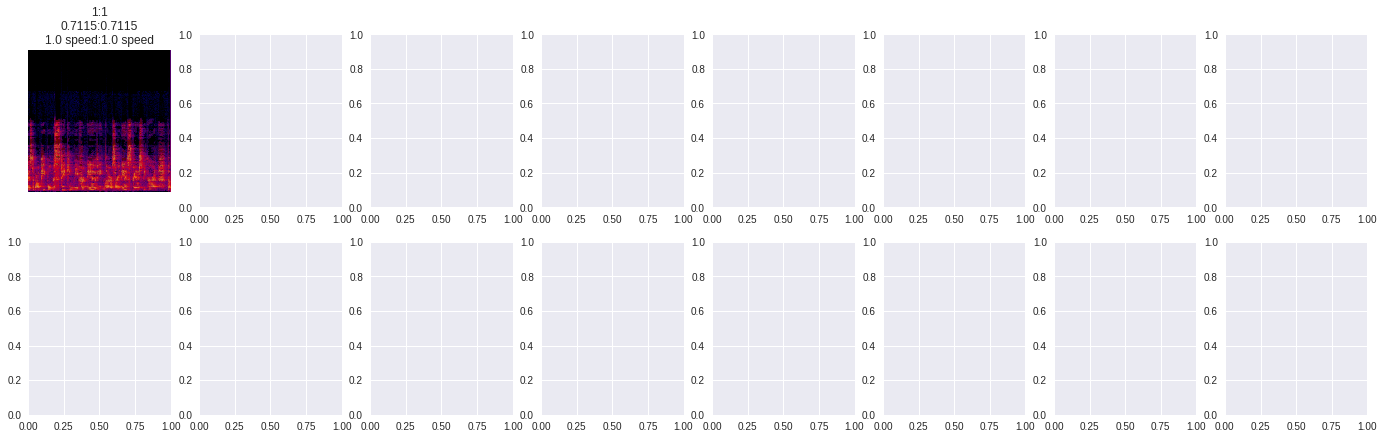

In [67]:
learner_efficientnetb0_v2.show_predictions(mode='test', correct=True, ascending=True)

In [68]:
print(classification_report(data_container.validation.y, learner_efficientnetb0_v1.predict_dataset().argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
learner_efficientnetb0_v1.evaluate_dataset(mode="test")

2/2 [==============================] - 0s 145ms/step - loss: 5.1592 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_2_categorical_accuracy: 1.0000


[5.1591925621032715, 0.0, 1.0]

In [70]:
print(classification_report(data_container.test.y, learner_efficientnetb0_v1.predict_dataset().argmax(axis=1)))

ValueError: ignored

test


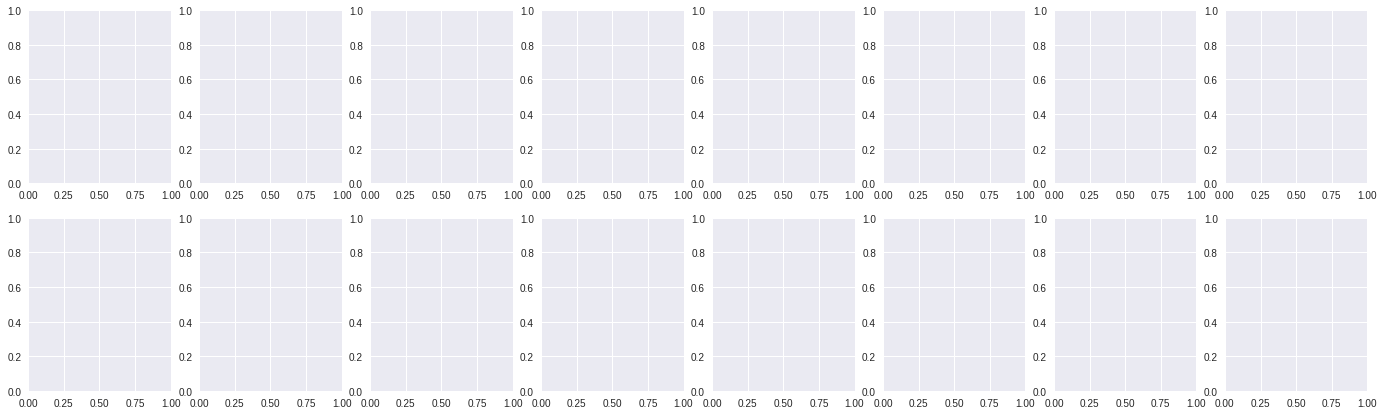

In [71]:
learner_efficientnetb0_v1.show_predictions(mode='test', correct=True, ascending=True)

## finished until here

We will check different architectures for training

In [0]:
def train_learner(learner, epochs=(0, 0, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print("-".center(90, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))
    
    return accuracy

In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [0]:
learners = []

for path, base_model in [
    LearnerParams('resnet50_v1', keras.applications.ResNet50),
    LearnerParams("mobilenetv2_v1", keras.applications.MobileNetV2),
    LearnerParams('xception_v1', keras.applications.Xception),
    LearnerParams("efficientnetb4_v1", efn.EfficientNetB4),
]:

    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=IMG_DIMS,
        dropout=0.5,
        l1=1e-5,
        l2=1e-4,
        override=True,
        load=True,
    )
    train_learner(learner)
    learners.append(learner.history.history.copy())
    del learner

For HP tunning

In [0]:
IMG_DIMS = (128, 128, 3)

In [0]:
data_container = DataContainer(
    train=ImageDataset.from_df(
        train_df,
        "image",
        "label",
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.4),
            ImageAugmentor(level=3, flips="both"),
        ],
        shuffle=True,
    ),
    test=ImageDataset.from_df(
        test_df,
        'image',
        "label",
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
    validation=ImageDataset.from_df(
        val_df,
        "image",
        "label",
        batch_size=2,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
                ImageParser(),
                ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
    ),
)

In [0]:
class ImageLearner_for_HP:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        
        self.best_model_arch_path =  str(TEMP_DIR/'best_model/best_model.json')
        self.best_model_weights_path = str(TEMP_DIR/'best_model/weights.json')
        
        self.logs_path = f'{self.path}/logs'

        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2

        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)

        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)

        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)

        self.save()

    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)

    def save_best_hp(self):
            save_keras_model(self.model, self.best_model_arch_path, self.best_model_weights_path)

    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)

    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                     keras.metrics.sparse_categorical_accuracy
            ],
        )

    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
    
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2

        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)

    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)

    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })

    def predict(self, path=None, image=None):
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, :]
        return self.model.predict(image)

    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, rows=2):
        print(mode)
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}"
            )

    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
dimensions = [
#     skopt.space.Categorical([
#         keras.optimizers.Adam,
#         keras.optimizers.Nadam,
#         keras.optimizers.RMSprop,
#     ], name='optimizer'),
    skopt.space.Real(low=1e-6, high=1e-3, prior='log-uniform', name='lr'),
    skopt.space.Real(low=0., high=0.5, name='dropout'),
#     skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l1_reg'),
#     skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l2_reg'),
    skopt.space.Integer(low=5, high=10, name='epochs'),
#     skopt.space.Integer(low=0, high=5, name='easing_epochs'),
]

In [0]:
default_parameters = [1e-4, 0.2, 2]

In [0]:
def train_learner_for_HP(learner, epochs=(1, 1, 1), lrs=(1e-4, 1e-4, 1e-4)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.Adam, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()

    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()

    print('-'.center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

    return accuracy

In [0]:
best_accuracy = 0.0

In [0]:
@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    lr,
    dropout,
    epochs,
):  
    learner_xception_v5 = ImageLearner_for_HP(
        path=TEMP_DIR/"xception_v5",
        data=data_container,
        base_model=keras.applications.Xception,
        input_shape=IMG_DIMS,
        dropout=dropout,
        l1=3e-5,
        l2=3e-4,
        override=True,
        load=True,
    )
    
    accuracy = train_learner_for_HP(learner_xception_v5, epochs=(3, epochs), lrs=(lr, lr, lr))


    print("\nAccuracy: {0:.2%}\n".format(accuracy))

    global best_accuracy

    if accuracy > best_accuracy:
        print('Best model'.center(80, '-'))
        print("Accuracy: {0:.4%}".format(accuracy))
        print(
            lr,
            dropout,
            epochs,
        )
        learner_xception_v5.save_best_hp()
        pd.DataFrame.from_dict({
           "lr": lr,
           "dropout": dropout,
           "epochs": epochs, 
        },orient='index').to_csv(TEMP_DIR/'best_model/best_model_params.csv')

        best_accuracy = accuracy

    del learner_xception_v5

    keras.backend.clear_session()

    return -accuracy

In [0]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=11,
    x0=default_parameters,
)

## Summary:




the best result with efficientnetB0 - 68% acc